# Supplements

We have run the *Monod* inference pipeline on six pre-clustered mouse brain cell glutamatergic subtypes, as well as the entire glutamatergic cell type. In this notebook, we analyze whether the amount of biological variation between the subtypes concords with the amount of biological variation predicted by normalization and mechanistic fit procedures.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()


In [ ]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/') #or wherever Monod may be

In [3]:
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
import scanpy as sc
import scipy
from scipy.sparse import hstack
from sklearn.decomposition import PCA
import umap
import decoupler

In [4]:
dir_string = './fits/gg_230328_026_allen_celltypes_1'

In [5]:
annotations_dir_loc = './data/'
raw_file_dir_loc = '/home/ggorin/count_data/loom_allen_kb/'

In [6]:
steps = ['PF','log','PCA','UMAP']

## data import

In [7]:
sample = 'B08'

In [8]:
allen_membership = pd.read_csv(annotations_dir_loc+'cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv(annotations_dir_loc+'cluster.annotation.csv')


In [9]:
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_membership = pd.concat((allen_membership,
                              allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)),
                              axis=1)


In [10]:
allen_membership = allen_membership[allen_membership['sample'] == sample]

In [11]:
allen_membership

,barcode,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
66697,AAACCCAAGTACGAGC-10L8TX_190430_01_B08,93,AAACCCAAGTACGAGC,B08,Vip Chat_low,Low Quality,Low Quality
66698,AAACCCAAGTGAACAT-10L8TX_190430_01_B08,42,AAACCCAAGTGAACAT,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
66699,AAACCCAAGTTGAATG-10L8TX_190430_01_B08,40,AAACCCAAGTTGAATG,B08,L2/3 IT,L2/3 IT,Glutamatergic
66700,AAACCCACACCCTAGG-10L8TX_190430_01_B08,100,AAACCCACACCCTAGG,B08,Sst Myh8_3_low,Low Quality,Low Quality
66701,AAACCCACACGATAGG-10L8TX_190430_01_B08,42,AAACCCACACGATAGG,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
...,...,...,...,...,...,...,...
75116,TTTGTTGAGGGTTAAT-10L8TX_190430_01_B08,140,TTTGTTGAGGGTTAAT,B08,L6 NP Trh_low,Low Quality,Low Quality
75117,TTTGTTGCAAAGGATT-10L8TX_190430_01_B08,24,TTTGTTGCAAAGGATT,B08,Sst Myh8_1,Sst,GABAergic
75118,TTTGTTGGTGAGGAAA-10L8TX_190430_01_B08,28,TTTGTTGGTGAGGAAA,B08,Sst Hpse_3,Sst,GABAergic
75119,TTTGTTGTCCAAACCA-10L8TX_190430_01_B08,40,TTTGTTGTCCAAACCA,B08,L2/3 IT,L2/3 IT,Glutamatergic


In [12]:
raw_file = raw_file_dir_loc+'allen_'+sample+'_raw.loom'
ad = sc.read_loom(raw_file)

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
ad = ad[ad.obs['barcode'].isin(allen_membership['cell_barcode'])]
ad.obs['total_cell_size'] = (ad.layers['spliced'].sum(1) + ad.layers['unspliced'].sum(1))
ad = ad[(ad.obs['total_cell_size'] > 1e4)]

/tmp/ipykernel_2190626/1577410883.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['total_cell_size'] = (ad.layers['spliced'].sum(1) + ad.layers['unspliced'].sum(1))


Merge in Allen annotations.

In [14]:
obs_df = ad.obs

In [15]:
obs_df=obs_df.merge(allen_membership,left_on='barcode',right_on='cell_barcode').drop(['barcode_x','barcode_y'],axis=1)

In [16]:
ad.obs=obs_df

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [17]:
ad.obs = ad.obs.set_index('cell_barcode')

In [18]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label
cell_barcode,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic


In [19]:
sd_string = dir_string+'/allen_B08_Glutamatergic/raw.sd'
sd = monod.analysis.load_search_data(sd_string)

In [20]:
ad.var = ad.var.set_index('gene_name').astype(str)

In [21]:
# ad.var.index.isin(sd.gene_names)

In [22]:
ad.var.index

Index(['AC125149.3', 'AC125149.1', 'AC125149.4', 'AC125149.2', 'AC125149.5',
       'AC133103.1', 'AC133103.5', 'AC133103.3', 'AC133103.6', 'AC133103.4',
       ...
       'Gm36929', 'Gm38296', 'Gm38013', 'Gm37561', 'Gm30686', 'Gm37657',
       'Gm36467', 'Gm37998', 'Gm37263', 'Gm37286'],
      dtype='object', name='gene_name', length=32285)

Select genes with relatively high spliced and unspliced expression.

In [23]:
ad = ad[:,ad.var.index.isin(sd.gene_names)]

In [24]:
ad

View of AnnData object with n_obs × n_vars = 7808 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced'

In [25]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label
cell_barcode,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic


In [26]:
ad.obs['sum_spliced_counts_filtered'] = ad.layers['spliced'].sum(1)

/tmp/ipykernel_2190626/3803360763.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['sum_spliced_counts_filtered'] = ad.layers['spliced'].sum(1)


In [27]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label,sum_spliced_counts_filtered
cell_barcode,,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12754.0
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,8521.0
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality,3433.0
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12358.0
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,10373.0
...,...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,9423.0
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic,8011.0
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic,12612.0


## Normalization

In [28]:
ad.layers['spliced_PF'] = (ad.layers['spliced'].toarray()
                           /np.array(ad.obs['sum_spliced_counts_filtered'])[:,None]
                           *ad.obs['sum_spliced_counts_filtered'].mean())

In [29]:
ad.layers['spliced_log'] = np.log(ad.layers['spliced_PF'] + 1)

In [30]:
pca_transformer = PCA(n_components=50)

In [31]:
pca_transformer.fit(ad.layers['spliced_log'])

PCA(n_components=50)

In [32]:
S_PCA_50D = pca_transformer.transform(ad.layers['spliced_log'])

In [33]:
S_PCA = pca_transformer.inverse_transform(S_PCA_50D)

In [34]:
ad.layers['spliced_PCA'] = S_PCA

In [35]:
umap_transformer = umap.UMAP()


In [36]:
umap_transformer.fit(S_PCA_50D)


UMAP(dens_frac=0.0, dens_lambda=0.0)

In [37]:
S_UMAP_2D = umap_transformer.transform(S_PCA_50D)


In [ ]:
S_UMAP_50D = umap_transformer.inverse_transform(S_UMAP_2D) #slow!

In [39]:
S_UMAP = pca_transformer.inverse_transform(S_UMAP_50D)

In [40]:
ad.layers['spliced_UMAP'] = S_UMAP

In [41]:
ad

AnnData object with n_obs × n_vars = 7808 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced', 'spliced_PF', 'spliced_log', 'spliced_PCA', 'spliced_UMAP'

## Extract data

Subset for the cell types we have fit using *Monod*.

In [42]:
subclasses_to_include = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subclasses_to_exclude = ['L6 IT Car3','L5 ET']
class_to_consider='Glutamatergic'

In [43]:
ad_subset = ad[(ad.obs['class_label']==class_to_consider) & 
              (ad.obs['subclass_label'].isin(subclasses_to_include))]

In [44]:
ad_subset

View of AnnData object with n_obs × n_vars = 5343 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced', 'spliced_PF', 'spliced_log', 'spliced_PCA', 'spliced_UMAP'

In [45]:
ad_subset.obs['subclass_label'].value_counts()

L5 IT      2382
L6 CT      1333
L2/3 IT     823
L6 IT       489
L5/6 NP     250
L6b          66
Name: subclass_label, dtype: int64

In [46]:
ad_subset.layers['spliced'] = ad_subset.layers['spliced'].toarray()

## Compute per-gene CV2

In [47]:
def get_cv2(ad_,layer):
    return ad_.layers[layer].var(0)/ad_.layers[layer].mean(0)**2

In [48]:
cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP = [get_cv2(ad_subset,x) 
                                           for x in ['spliced','spliced_PF','spliced_log','spliced_PCA','spliced_UMAP']]
cv2s = np.asarray([cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP])

In [49]:
total_mean = ad_subset.layers['spliced'].mean(0)
q = np.quantile(total_mean,0.95)
gf = total_mean<q

Text(0.5, 1.0, 'CV2')

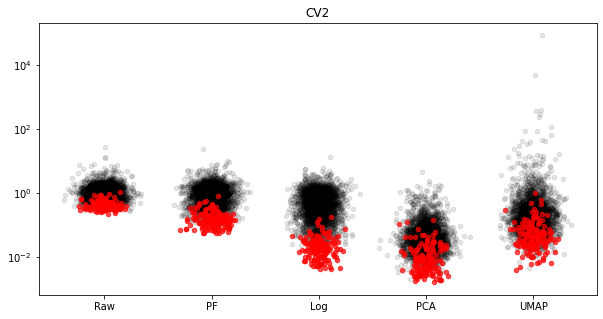

In [50]:
n_genes = len(ad_subset.var)
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2s[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2s[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'])
ax1.set_title('CV2')

CV2s and CV2 fractions are here.

In [51]:
cv2_fracs = np.array([cv2s[i]/cv2s[0] for i in range(1,5)])

Text(0.5, 1.0, 'CV2 fractions')

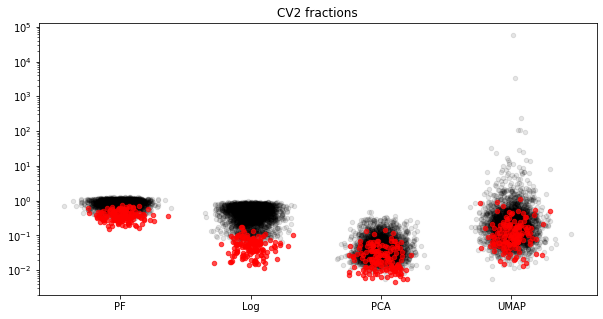

In [52]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(4):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2_fracs[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2_fracs[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(4),['PF','Log','PCA','UMAP'])
ax1.set_title('CV2 fractions')


In [53]:
total_mean = ad_subset.layers['spliced'].mean(0)
total_variance = ad_subset.layers['spliced'].var(0)

In [54]:
subclass_abundances = []
subclass_means = []
for subclass in subclasses_to_include:
    subclass_mean = ad_subset[ad_subset.obs['subclass_label']==subclass].layers['spliced'].mean(0)
    subclass_means.append(subclass_mean)
    subclass_abundances.append((ad_subset.obs['subclass_label']==subclass).mean())
subclass_abundances = np.asarray(subclass_abundances)
subclass_means = np.asarray(subclass_means)
baseline = (((subclass_means-total_mean[None,:])**2) * subclass_abundances[:,None]).sum(0) / total_variance

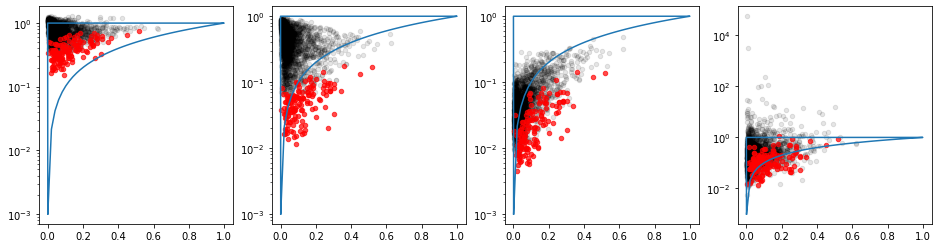

In [55]:
fig1,ax1=plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax1[i].scatter(baseline[gf],cv2_fracs[i,gf],20,'k',alpha=0.1)
    ax1[i].scatter(baseline[~gf],cv2_fracs[i,~gf],20,'r',alpha=0.7)
    ax1[i].set_yscale('log')
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[i].plot(region_x,region_y)
#     ax1[i].set_ylim([cv2_fracs[i].min()*0.9,cv2_fracs[i].max()*1.1])


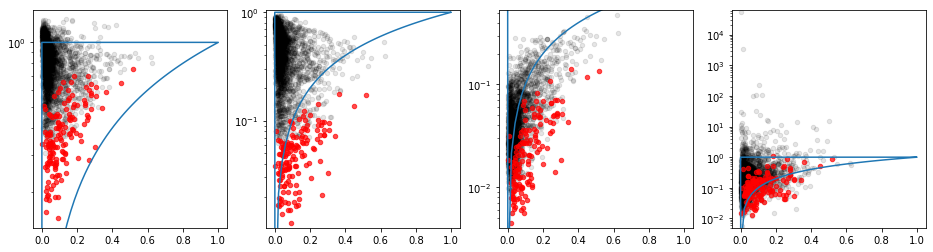

In [56]:
fig1,ax1=plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax1[i].scatter(baseline[gf],cv2_fracs[i,gf],20,'k',alpha=0.1)
    ax1[i].scatter(baseline[~gf],cv2_fracs[i,~gf],20,'r',alpha=0.7)
    ax1[i].set_yscale('log')
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[i].plot(region_x,region_y)
    ax1[i].set_ylim([cv2_fracs[i].min()*0.9,cv2_fracs[i].max()*1.1])


## Spliced/unspliced analysis

Create the auxiliary object `ad_su` that concatenates spliced and unspliced measurements.

In [57]:
ad

AnnData object with n_obs × n_vars = 7808 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced', 'spliced_PF', 'spliced_log', 'spliced_PCA', 'spliced_UMAP'

In [58]:
ad.layers['spliced']

<7808x2951 sparse matrix of type '<class 'numpy.float32'>'
	with 15752115 stored elements in Compressed Sparse Row format>

In [59]:
hstack((ad.layers['spliced'], ad.layers['unspliced'])).tocsr()

<7808x5902 sparse matrix of type '<class 'numpy.float32'>'
	with 31296960 stored elements in Compressed Sparse Row format>

In [60]:
ad_su = anndata.AnnData(X=hstack((ad.layers['spliced'], ad.layers['unspliced'])).tocsr(),
                        obs=ad.obs,
                        var=np.concatenate([ad.var.index,ad.var.index+'_U']))

In [61]:
ad_su.var=ad_su.var.rename(columns={0:'gene_name'})

In [62]:
ad_su.var = ad_su.var.set_index('gene_name').astype(str)

In [63]:
ad_su

AnnData object with n_obs × n_vars = 7808 × 5902
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered'

In [64]:
ad_su.layers['su']=ad_su.X

In [65]:
ad_su.layers['su']

<7808x5902 sparse matrix of type '<class 'numpy.float32'>'
	with 31296960 stored elements in Compressed Sparse Row format>

In [66]:
ad_su.obs['sum_counts_filtered'] = ad_su.layers['su'].sum(1)

In [67]:
ad_su.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label,sum_spliced_counts_filtered,sum_counts_filtered
cell_barcode,,,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12754.0,26907.0
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,8521.0,17769.0
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality,3433.0,21607.0
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12358.0,29904.0
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,10373.0,19159.0
...,...,...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,9423.0,16214.0
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic,8011.0,16776.0
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic,12612.0,25923.0


In [68]:
ad_su.layers['su_PF'] = (ad_su.layers['su'].toarray()
                           /np.array(ad_su.obs['sum_counts_filtered'])[:,None]
                           *ad_su.obs['sum_counts_filtered'].mean())


In [69]:
ad_su.layers['su_log'] = np.log(ad_su.layers['su_PF'] + 1)


In [70]:
pca_transformer = PCA(n_components=50)
pca_transformer.fit(ad_su.layers['su_log'])
SU_PCA_50D = pca_transformer.transform(ad_su.layers['su_log'])
SU_PCA = pca_transformer.inverse_transform(SU_PCA_50D)
ad_su.layers['su_PCA'] = SU_PCA


In [71]:
umap_transformer = umap.UMAP() 
umap_transformer.fit(SU_PCA_50D)
SU_UMAP_2D = umap_transformer.transform(SU_PCA_50D) 
SU_UMAP_50D = umap_transformer.inverse_transform(SU_UMAP_2D) #slow...
SU_UMAP = pca_transformer.inverse_transform(SU_UMAP_50D)
ad_su.layers['su_UMAP'] = SU_UMAP

### Extract data

Subset again.

In [72]:
ad_su_subset = ad_su[(ad_su.obs['class_label']==class_to_consider) & 
              (ad_su.obs['subclass_label'].isin(subclasses_to_include))]

In [73]:
ad_su_subset.X

<5343x5902 sparse matrix of type '<class 'numpy.float32'>'
	with 23090839 stored elements in Compressed Sparse Row format>

In [74]:
ad_su_subset.layers['su'] = ad_su_subset.layers['su'].tocsr().toarray()

In [75]:
ad_su_subset

AnnData object with n_obs × n_vars = 5343 × 5902
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered', 'sum_counts_filtered'
    layers: 'su', 'su_PF', 'su_log', 'su_PCA', 'su_UMAP'

Compute spliced/unspliced correlations.

In [76]:
def get_SU_corrs(ad_,layer,genes,kind='pearson'):
    corrs = []
    if kind=='pearson':
        corrfun = lambda x,y: scipy.stats.pearsonr(x,y)[0]
    elif kind=='spearman':
        corrfun = lambda x,y: scipy.stats.spearmanr(x,y)[0]
    for gene in genes:
        x = ad_[:,gene].layers[layer].squeeze()
        y = ad_[:,gene+'_U'].layers[layer].squeeze()
        corr = corrfun(x,y)
        corrs.append(corr)
    return np.array(corrs)

In [77]:
genes=ad.var.index
corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP = [get_SU_corrs(ad_su_subset,x,genes) 
                                           for x in ['su','su_PF','su_log','su_PCA','su_UMAP']]
corrs = np.asarray([corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP])

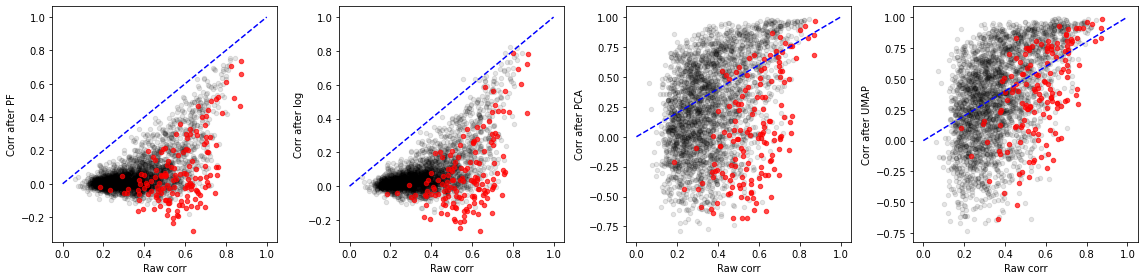

In [78]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
    ax1[i].scatter(corrs[0,gf],corrs[i+1,gf],20,'k',alpha=0.1)
    ax1[i].scatter(corrs[0,~gf],corrs[i+1,~gf],20,'r',alpha=0.7)
    xl = [0,1]
    ax1[i].plot(xl,xl,'b--')
    ax1[i].set_xlabel('Raw corr')
    ax1[i].set_ylabel('Corr after '+steps[i])

fig1.tight_layout()


## Gene-gene correlations

Get gene-gene correlations in the concatenated matrix.

In [79]:
ad_su_subset

AnnData object with n_obs × n_vars = 5343 × 5902
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered', 'sum_counts_filtered'
    layers: 'su', 'su_PF', 'su_log', 'su_PCA', 'su_UMAP'

In [80]:
def get_SU_corr_percentiles(ad_,layer,su_corrs,genes,kind='pearson'):
    if kind=='pearson':
        cc = np.corrcoef(ad_.layers[layer][:,:len(genes)].T)
    percentile = (cc<su_corrs[:,None]).mean(1)
    return percentile

In [81]:
genes=ad.var.index #rather slow
corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP = [get_SU_corrs(ad_su_subset,x,genes) 
                                           for x in ['su','su_PF','su_log','su_PCA','su_UMAP']]
corrs = np.asarray([corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP])

In [82]:
perc_raw,perc_PF,perc_log,perc_PCA,perc_UMAP = [get_SU_corr_percentiles(ad_su_subset,x,corrs[i],genes) 
                                           for i,x in enumerate(['su','su_PF','su_log','su_PCA','su_UMAP'])]
percentiles = np.asarray([perc_raw,perc_PF,perc_log,perc_PCA,perc_UMAP])

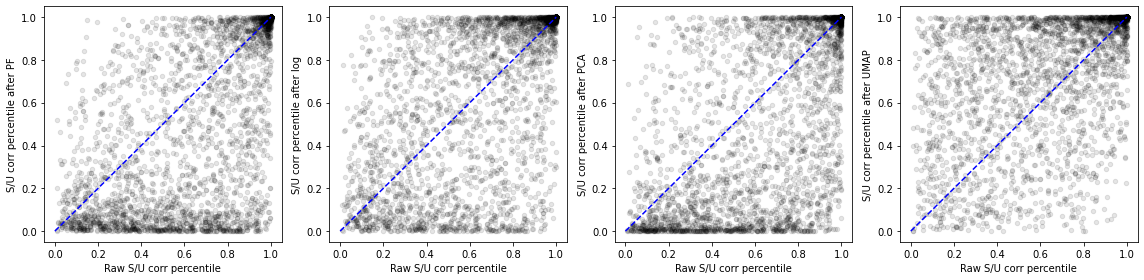

In [83]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
    ax1[i].scatter(percentiles[0],percentiles[i+1],20,'k',alpha=0.1)
#     ax1[i].scatter(rhos[0,~gf],rhos[i+1,~gf],20,'r',alpha=0.7)
    xl = [0,1]
    ax1[i].plot(xl,xl,'b--')
    ax1[i].set_xlabel('Raw S/U corr percentile')
    ax1[i].set_ylabel('S/U corr percentile after '+steps[i])

fig1.tight_layout()


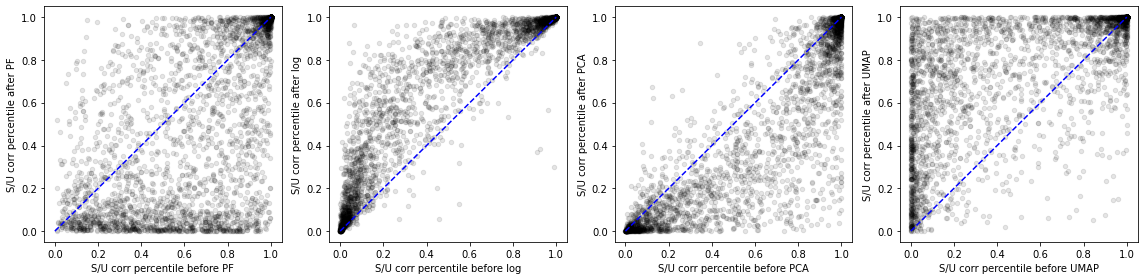

In [84]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
    ax1[i].scatter(percentiles[i],percentiles[i+1],20,'k',alpha=0.1)
#     ax1[i].scatter(rhos[0,~gf],rhos[i+1,~gf],20,'r',alpha=0.7)
    xl = [0,1]
    ax1[i].plot(xl,xl,'b--')
    ax1[i].set_xlabel('S/U corr percentile before '+steps[i])
    ax1[i].set_ylabel('S/U corr percentile after '+steps[i])

fig1.tight_layout()


## Ranks of abs

In [85]:
def get_SU_corr_percentiles_abs(ad_,layer,su_corrs,genes,kind='pearson'):
    if kind=='pearson':
        cc = np.corrcoef(ad_.layers[layer][:,:len(genes)].T)
    percentile = (np.abs(cc)<np.abs(su_corrs[:,None])).mean(1)
    return percentile

In [87]:
genes=ad.var.index
# corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP = [get_SU_corrs(ad_su_subset,x,genes) 
#                                            for x in ['su','su_PF','su_log','su_PCA','su_UMAP']]
# corrs = np.asarray([corr_raw,corr_PF,corr_log,corr_PCA,corr_UMAP])

In [88]:
perc_raw,perc_PF,perc_log,perc_PCA,perc_UMAP = [get_SU_corr_percentiles_abs(ad_su_subset,x,corrs[i],genes) 
                                           for i,x in enumerate(['su','su_PF','su_log','su_PCA','su_UMAP'])]
percentiles_abs = np.asarray([perc_raw,perc_PF,perc_log,perc_PCA,perc_UMAP])

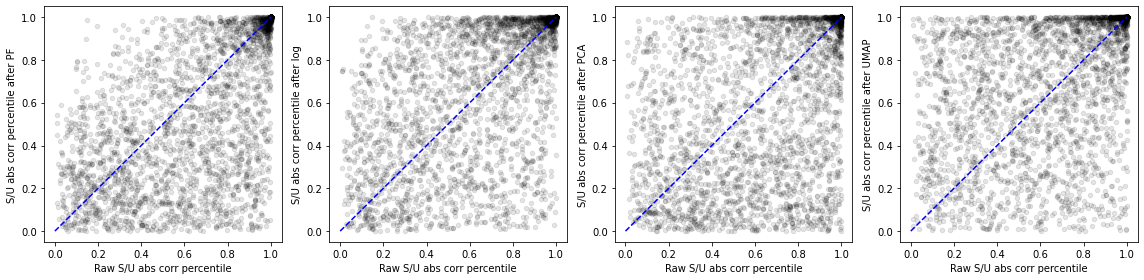

In [89]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
    ax1[i].scatter(percentiles_abs[0],percentiles_abs[i+1],20,'k',alpha=0.1)
#     ax1[i].scatter(rhos[0,~gf],rhos[i+1,~gf],20,'r',alpha=0.7)
    xl = [0,1]
    ax1[i].plot(xl,xl,'b--')
    ax1[i].set_xlabel('Raw S/U abs corr percentile')
    ax1[i].set_ylabel('S/U abs corr percentile after '+steps[i])

fig1.tight_layout()


In [90]:
thr=0.9
print('percentiles before/after')
for i in range(4):
    print(((percentiles_abs[i]>thr) & (percentiles_abs[i+1]>thr)).mean())
print('percentiles raw/after')
for i in range(4):
    print(((percentiles_abs[0]>thr) & (percentiles_abs[i+1]>thr)).mean())

percentiles before/after
0.2219586580820061
0.27719417146729924
0.29278210776008134
0.2555066079295154
percentiles raw/after
0.2219586580820061
0.25008471704506946
0.21145374449339208
0.2351745171128431


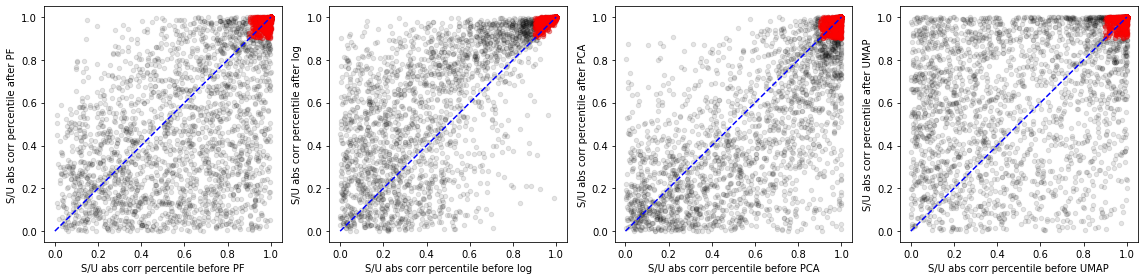

In [91]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

for i in range(4):
    ax1[i].scatter(percentiles_abs[i,],percentiles_abs[i+1],20,'k',alpha=0.1)
    ax1[i].scatter(percentiles_abs[i,(percentiles_abs[i]>thr) & (percentiles_abs[i+1]>thr)],percentiles_abs[i+1,(percentiles_abs[i]>thr) & (percentiles_abs[i+1]>thr)],20,'r',alpha=0.3)
#     ax1[i].scatter(rhos[0,~gf],rhos[i+1,~gf],20,'r',alpha=0.7)
    xl = [0,1]
    ax1[i].plot(xl,xl,'b--')
    ax1[i].set_xlabel('S/U abs corr percentile before '+steps[i])
    ax1[i].set_ylabel('S/U abs corr percentile after '+steps[i])

fig1.tight_layout()


## *Monod*: U/S correlations

In [92]:
subcluster_names = subclasses_to_include
# subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
dataset_meta = ['B08']
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

n_datasets = len(dataset_names)    
sr = monod.analysis.load_search_results(result_strings[-1])


In [93]:
li = sr.samp_optimum_ind

p = 10**sr.param_estimates[li] #b, beta, gamma
l = 10**sr.regressor[li]

p=p.T
l=l.T

In [94]:
sd_strings = [dir_string + '/' + x + '/raw.sd' for x in dataset_names]
sd = monod.analysis.load_search_data(sd_strings[-1])

In [95]:
_=sr.chisquare_testing(sd,threshold=0.01) #a bit slow

In [96]:
sr.rejected_genes.sum()

387

In [97]:
cov_nm_bio = p[0]**2/(p[1]+p[2])
mu_n_bio_glu =  p[0]/p[1]
var_n_bio_glu = mu_n_bio_glu*(1+p[0])
mu_m_bio_glu =  p[0]/p[2]
var_m_bio_glu = mu_m_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

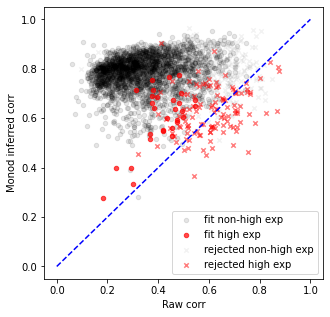

In [98]:
fig1,ax1=plt.subplots(1,1,figsize=(5,5))

ax1.scatter(corrs[0][gf&(~sr.rejected_genes)],corr_nm_bio[gf&(~sr.rejected_genes)],20,'k',alpha=0.1,label='fit non-high exp')
ax1.scatter(corrs[0][~gf&(~sr.rejected_genes)],corr_nm_bio[~gf&(~sr.rejected_genes)],20,'r',alpha=0.7,label='fit high exp')

ax1.scatter(corrs[0][gf&(sr.rejected_genes)],corr_nm_bio[gf&(sr.rejected_genes)],20,'k',alpha=0.05,marker='x',label='rejected non-high exp')
ax1.scatter(corrs[0][~gf&(sr.rejected_genes)],corr_nm_bio[~gf&(sr.rejected_genes)],20,'r',alpha=0.5,marker='x',label='rejected high exp')
xl=[0,1]
ax1.plot(xl,xl,'b--')
ax1.set_xlabel('Raw corr')
ax1.set_ylabel('Monod inferred corr')
ax1.legend()

## *Monod*: cell type differences

Perform analysis on mechanistic fit.

In [99]:
subcluster_names = subclasses_to_include
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
n_datasets = len(dataset_names)

In [100]:
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [101]:
result_strings

['./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/grid_scan_results_upd.res']

Import results.

In [102]:
opt = []
n_cells = []
sr_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    opt.append(sr.samp_optimum)
    n_cells.append(sr.n_cells)
    sr_arr.append(sr)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [103]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

Where should we set the sampling parameters? The results for low-abundance cell types are questionable. We somewhat arbitrarily set the parameters for all to the glutamatergic result.

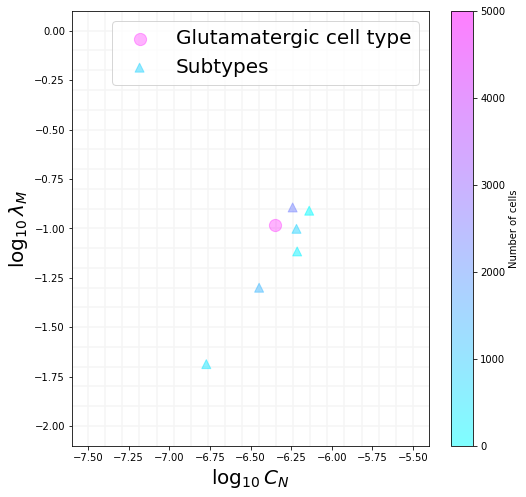

In [104]:
fs = 20

d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.01
opt_ = opt+jit
cmap = 'cool'

ctf = range(6,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],150,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='Glutamatergic cell type',vmin=0,vmax=5000)
stf = range(6)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='Subtypes',vmin=0,vmax=5000)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = './figs/landscape_qc_allen.png'
plt.savefig(fig_string,dpi=450)


For this analysis, we ignore goodness of fit and confidence intervals, because it is not entirely clear how to integrate them.

In [105]:
model_moments = []
li = sr_arr[-1].samp_optimum_ind
for j in range(n_datasets-1):

    p = 10**sr_arr[j].param_estimates[li] #b, beta, gamma
    l = 10**sr_arr[j].regressor[li]
    
    p=p.T
    l=l.T
    mu_bio =  p[0]/p[2]
    mu_tech = mu_bio * l[1]
    var_bio = mu_bio*(1+p[0]*p[1]/(p[1]+p[2]))
    var_tech = mu_tech*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
    model_moments.append((mu_bio,mu_tech,var_bio,var_tech))
    
model_moments = np.asarray(model_moments)


In [106]:
pi = subclass_abundances

In [107]:
mean_bio = (model_moments[:,0,:]*pi[:,None]).sum(0)
var_bio = (model_moments[:,2,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,0,:]-mean_bio)**2)*pi[:,None]).sum(0)

mean_tech = (model_moments[:,1,:]*pi[:,None]).sum(0)
var_tech = (model_moments[:,3,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,1,:]-mean_tech)**2)*pi[:,None]).sum(0)

cv2_bio = var_bio/mean_bio**2
cv2_tech = var_tech/mean_tech**2
cv2_monod_frac = cv2_bio/cv2_tech


(-0.1, 1.0)

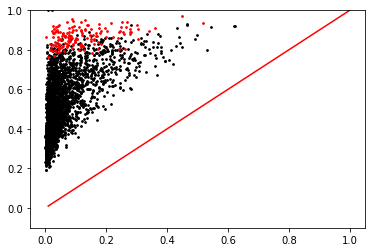

In [108]:
plt.scatter(baseline[gf],cv2_monod_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_monod_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,1])

# Fig 1 b-h

Plot the noise fractions and attributions for the PF, log, PCA, and UMAP.

In [109]:
# a e s t h e t i c s
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 20
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'

0.0
0.07556760420196544
0.43612334801762115
0.07624534056252118


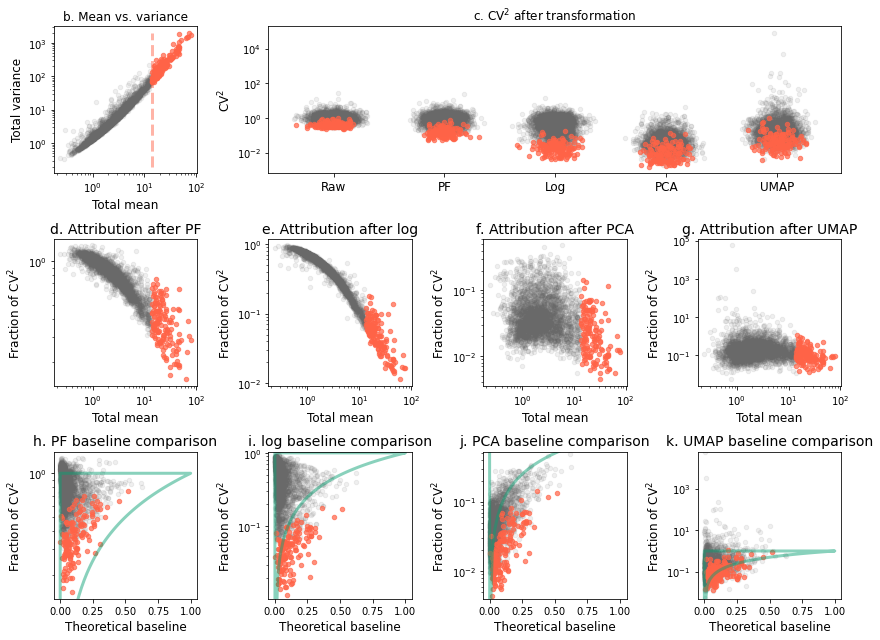

In [110]:
fig1,ax1=plt.subplots(3,4,figsize=(12,9))

fl = 97+1
#mean-variance relationship
ax1[0,0].scatter(total_mean[gf],total_variance[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0,0].scatter(total_mean[~gf],total_variance[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0,0].plot([q]*2,[2e-1,2e3],'--',color=c_highlight,alpha=alpha_line,linewidth=lw)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0,0].set_ylabel('Total variance',fontsize=fs_axes)
ax1[0,0].set_title('{}. Mean vs. variance'.format(chr(fl)))

#cv2
gs = ax1[0,1].get_gridspec()
for ax in ax1[0,1:]:
    ax.remove()
axcv2 = fig1.add_subplot(gs[0,1:])
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    axcv2.scatter(xlocs[gf],cv2s[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    axcv2.scatter(xlocs[~gf],cv2s[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
axcv2.set_yscale('log')
axcv2.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'],fontsize=fs_axes)
axcv2.set_ylabel(r'CV$^2$',fontsize=fs_axes)
axcv2.set_title('{}. CV$^2$ after transformation'.format(chr(fl+1)))

#mean dependence
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(total_mean[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(total_mean[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    ax1[1,k].set_xscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_xlabel('Total mean',fontsize=fs_axes)
    ax1[1,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    ax1[1,k].set_title('{}. Attribution after {}'.format(chr(fl+2+k),names[k]),fontsize=fs_title)

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[2,k].scatter(baseline[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[2,k].scatter(baseline[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    
    
    gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    print(gf_.sum()/len(gf_))
    
    ax1[2,k].set_yscale('log')
    ax1[2,k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[2,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[2,k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[2,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[2,k].set_xticks(np.linspace(0,1,5))
    ax1[2,k].set_title('{}. {} baseline comparison'.format(chr(fl+6+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig1b_k.png',dpi=450)
fig1.savefig('./figs/fig1b_k.pdf')


## Supplement to Fig. 1

Even if UMAP inflates the CV$^2$, how much information have we lost previously in the process?

0.0
0.07556760420196544
0.43612334801762115
0.4442561843442901


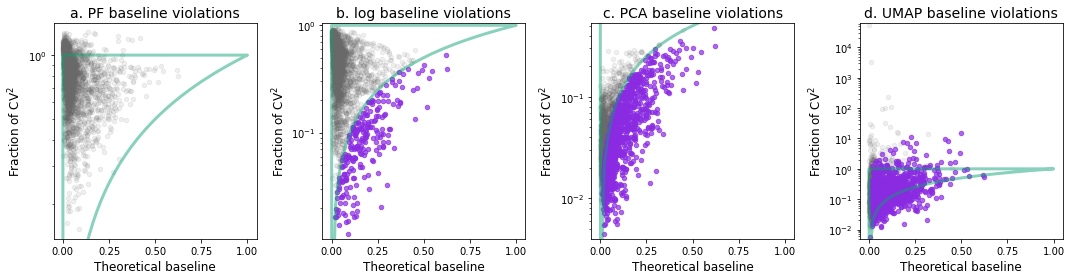

In [111]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    if k==0:
        gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    else:
        gf_ = gf_|(cv2_fracs[k]<baseline)
    print(gf_.sum()/len(gf_))
    ax1[k].scatter(baseline[~gf_],cv2_fracs[k][~gf_],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(baseline[gf_],cv2_fracs[k][gf_],ms_highlight,c_baseline_violation,alpha=alpha_highlight)
    ax1[k].set_yscale('log')
    ax1[k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xticks(np.linspace(0,1,5))
    ax1[k].set_title('{}. {} baseline violations'.format(chr(97+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/baseline_violation.png',dpi=450)
fig1.savefig('./figs/baseline_violation.pdf')


# Fig 2 b-c

How much of the CV$^2$ does a mechanistic approach ascribe to biology?

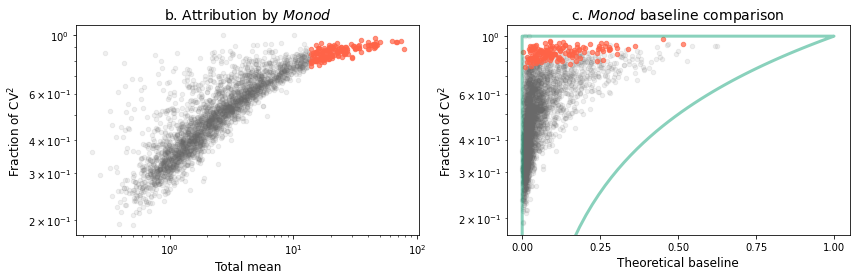

In [112]:
fig1,ax1=plt.subplots(1,2,figsize=(12,4))

# #mean dependence
ax1[0].scatter(total_mean[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0].scatter(total_mean[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1[0].set_title('{}. '.format(chr(97+1))+r'Attribution by $\it{Monod}$',fontsize=fs_title)


ax1[1].scatter(baseline[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[1].scatter(baseline[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1[1].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1[1].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1[1].set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1[1].set_xticks(np.linspace(0,1,5))
ax1[1].set_title('{}. '.format(chr(97+2))+r'$\it{Monod}$ baseline comparison',fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig2bc.png',dpi=450)
fig1.savefig('./figs/fig2bc.pdf')


## Supplements to Fig. 2

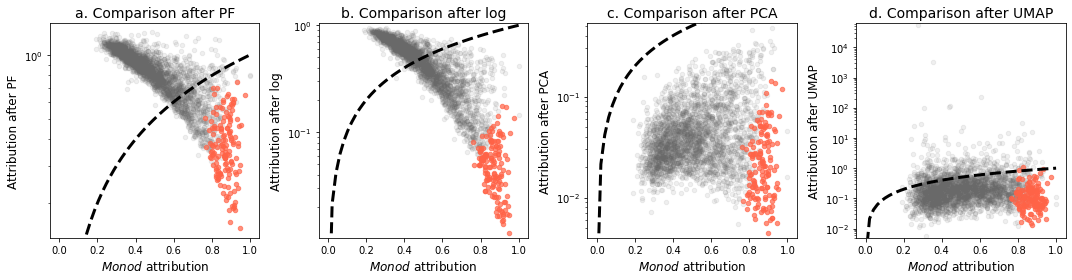

In [113]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[k].scatter(cv2_monod_frac[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(cv2_monod_frac[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[k].set_yscale('log')
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[k].set_title('{}. Comparison after {}'.format(chr(97+k),names[k]),fontsize=fs_title)
fig1.tight_layout()
fig1.savefig('./figs/monod_norm_comparison.png',dpi=450)
fig1.savefig('./figs/monod_norm_comparison.pdf')


What if we fit the entire dataset using *Monod*, without giving the cell type annotations? After all, our aggregation procedure "automatically" applies the law of total variance. It turns out this makes very little difference.

In [114]:
# model_moments = []
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[-1].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[-1].regressor[li]

p=p.T
l=l.T
mu_bio_glu =  p[0]/p[2]
mu_tech_glu = mu_bio_glu * l[1]
var_bio_glu = mu_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
var_tech_glu = mu_tech_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
cv2_bio_glu = var_bio_glu/mu_bio_glu**2
cv2_tech_glu = var_tech_glu/mu_tech_glu**2
cv2_monod_frac_glu = cv2_bio_glu/cv2_tech_glu


In [115]:
# p.sha

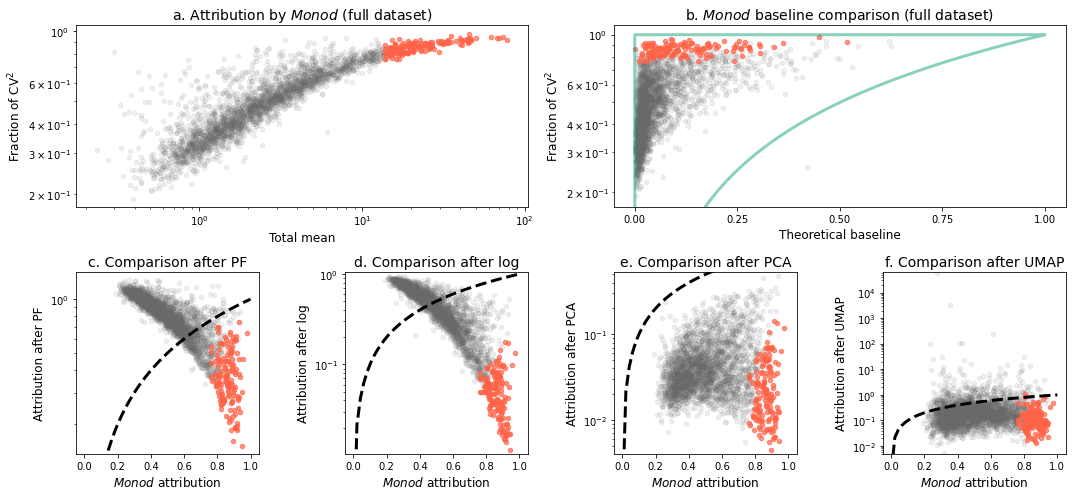

In [116]:
# fig1,ax1=plt.subplots(1,2,figsize=(12,6))
fig1,ax1=plt.subplots(2,4,figsize=(15,7))


gs = ax1[0,0].get_gridspec()
for ax in ax1[0,0:2]:
    ax.remove()
ax1_a = fig1.add_subplot(gs[0,0:2])
ax1_a.scatter(total_mean[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_a.scatter(total_mean[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_a.set_xscale('log')
ax1_a.set_yscale('log')
ax1_a.set_xlabel('Total mean',fontsize=fs_axes)
ax1_a.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1_a.set_title('{}. '.format(chr(97))+r'Attribution by $\it{Monod}$ (full dataset)',fontsize=fs_title)

gs = ax1[0,2].get_gridspec()
for ax in ax1[0,2:]:
    ax.remove()
ax1_b = fig1.add_subplot(gs[0,2:])
ax1_b.scatter(baseline[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_b.scatter(baseline[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_b.set_yscale('log')
ax1_b.set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1_b.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1_b.plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1_b.set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1_b.set_xticks(np.linspace(0,1,5))
ax1_b.set_title('{}. '.format(chr(97+1))+r'$\it{Monod}$ baseline comparison (full dataset)',fontsize=fs_title)

names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(cv2_monod_frac_glu[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(cv2_monod_frac_glu[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[1,k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[1,k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[1,k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[1,k].set_title('{}. Comparison after {}'.format(chr(97+k+2),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/monod_glu.png',dpi=450)
fig1.savefig('./figs/monod_glu.pdf')


Stop here.

# Correlations

In [275]:
p.shape

(3, 2951)

In [276]:
c2 = -1

In [277]:
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[c2].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[c2].regressor[li]

p=p.T
l=l.T

In [278]:
dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b',
 'allen_B08_Glutamatergic']

In [279]:
sd = monod.analysis.load_search_data(sd_strings[c2])


In [280]:
for x in sr_arr:
    x.set_sampling_optimum(li)

In [281]:
_=sr_arr[c2].chisquare_testing(sd,threshold=0.01)

KeyboardInterrupt: 

In [282]:
sr_arr[c2].rejected_genes.sum()

387

In [283]:
sd.layers.shape

(2, 2951, 5343)

In [284]:
SU_corr_l6 = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(sd.layers[0],sd.layers[1])])


In [285]:
SU_corr_l6.shape

(2951,)

In [286]:
cov_nm_bio = p[0]**2/(p[1]+p[2])
mu_n_bio_glu =  p[0]/p[1]
var_n_bio_glu = mu_n_bio_glu*(1+p[0])
mu_m_bio_glu =  p[0]/p[2]
var_m_bio_glu = mu_m_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

In [287]:
corr_nm_bio[sr_arr[c2].rejected_genes]=np.nan

In [288]:
# cov_nm_bio = l[0]*l[1]*p[0]**2/(p[1]+p[2])
# mu_n_bio_glu =  l[0]*p[0]/p[1]
# var_n_bio_glu = mu_n_bio_glu*(1+l[0]*(1+p[0]))
# mu_m_bio_glu =  l[1]*p[0]/p[2]
# var_m_bio_glu = mu_m_bio_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
# corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

(array([   3.,    3.,    0.,   27.,   68.,  154.,  482., 1024.,  714.,
          89.]),
 array([0.27884348, 0.34636394, 0.41388441, 0.48140488, 0.54892535,
        0.61644581, 0.68396628, 0.75148675, 0.81900721, 0.88652768,
        0.95404815]),
 <BarContainer object of 10 artists>)

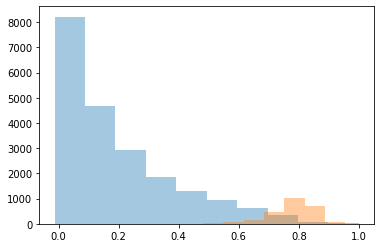

In [289]:
plt.hist(SU_corr,alpha=0.4)
plt.hist(corr_nm_bio,alpha=0.4)

In [290]:
zr = np.log((1+corr_nm_bio)/(1-corr_nm_bio))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
ypos = U_-corr_nm_bio
yneg = corr_nm_bio-L

In [291]:
zr = np.log((1+SU_corr_l6)/(1-SU_corr_l6))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
xpos = U_-SU_corr_l6
xneg = SU_corr_l6-L

In [292]:
(~gf).sum()

148

Text(0, 0.5, 'Predicted biological N/M correlation')

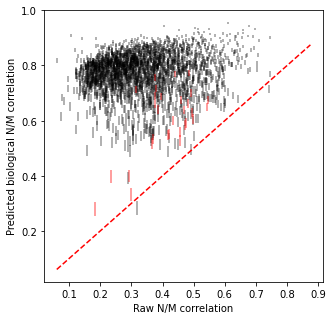

In [293]:
# plt.errorbar(SU_corr_l6,corr_nm_bio,yerr=np.asarray([yneg,ypos]),linestyle='',alpha=0.4,color='k')
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr_l6),max(SU_corr_l6)]
# ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],xerr=np.asarray([xneg[gf],xpos[gf]]),linestyle='',alpha=0.4,color='k')
# ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],xerr=np.asarray([xneg[~gf],xpos[~gf]]),linestyle='',alpha=0.5,color='r')

ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],yerr=np.asarray([yneg[gf],ypos[gf]]),linestyle='',alpha=0.4,color='k')
ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],yerr=np.asarray([yneg[~gf],ypos[~gf]]),linestyle='',alpha=0.5,color='r')
ax1.plot(xl,xl,'r--')

ax1.set_xlabel('Raw N/M correlation')
ax1.set_ylabel('Predicted biological N/M correlation')

In [294]:
sd.gene_names[~gf]

array(['Inpp4a', 'Ptprn', 'Itm2c', 'Epha4', 'Atp1b1', 'Lpgat1', 'Psap',
       'Serinc1', 'Zwint', 'Ank3', 'Spock2', 'Actr2', 'Camk2b', 'Hlf',
       'Sptbn1', 'Rbfox3', 'Nsg2', 'Adcy1', 'Gabra1', 'Ddx5', 'Pafah1b1',
       'Nsf', 'Prkar1a', 'Rtn4', 'Ywhae', 'Cyfip2', 'Mapt', 'Rock2',
       'Myt1l', 'Rtn1', 'Vsnl1', 'Rian', 'Mef2c', 'Cplx2', 'Rgs7bp',
       'Map1b', 'Ntrk2', 'Smim13', 'Ppp3cb', 'Dpysl2', 'Fzd3', 'Mycbp2',
       'Cntn1', 'Ywhaz', 'Arf3', 'Basp1', 'Scn8a', 'Ncald', 'App',
       'Gsk3b', 'Atp6v1a', 'Mapk1', 'Cd47', 'Ttc3', 'Synj1', 'Pja2',
       'Ptprs', 'Slc8a1', 'Prkce', 'Celf4', 'Impact', 'Ndfip1', 'Camk2a',
       'Pura', 'Tcf4', 'Pten', 'Gnaq', 'Rtn3', 'Klf9', 'Gda', 'Ywhab',
       'Kif5c', 'Olfm1', 'Scn2a', 'Nckap1', 'Napb', 'Stxbp1', 'Fam171b',
       'Kcnb1', 'Ndrg3', 'Chn1', 'Dnajc5', 'Dnm1', 'Slc12a5', 'Rasgrp1',
       'Stmn3', 'Prkacb', 'Stmn2', 'Sec62', 'Rap1gds1', 'Atp1a1', 'Ank2',
       'Dclk1', 'Plppr4', 'Gria2', 'Syt11', 'Hpca', 'Kif1b', 'Gnb1',
  

In [295]:
gf_violat = corr_nm_bio<SU_corr_l6

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  5.47016863,   8.74701148,  12.02385433,  15.30069717,
         18.57754002,  21.85438286,  25.13122571,  28.40806855,
         31.6849114 ,  34.96175424,  38.23859709,  41.51543993,
         44.79228278,  48.06912562,  51.34596847,  54.62281132,
         57.89965416,  61.17649701,  64.45333985,  67.7301827 ,
         71.00702554,  74.28386839,  77.56071123,  80.83755408,
         84.11439692,  87.39123977,  90.66808261,  93.94492546,
         97.22176831, 100.49861115, 103.775454  ]),
 <BarContainer object of 30 artists>)

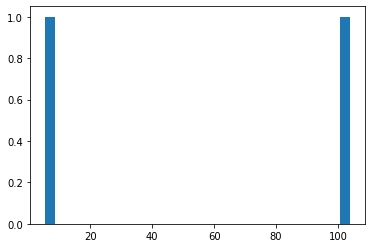

In [296]:
plt.hist(p[0,gf_violat],30)

In [297]:
((~gf)&gf_violat).sum()

0

In [298]:
(corr_nm_bio<SU_corr_l6).sum()

2

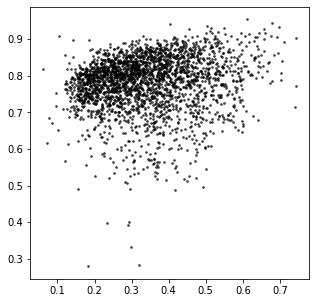

In [299]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6,corr_nm_bio,3,'k',alpha=0.6)
ax1.plot(xl,xl,'r--')


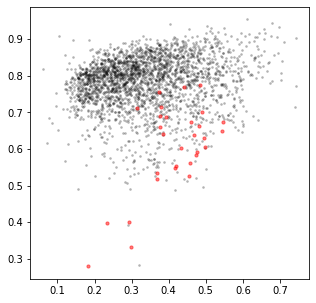

In [300]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6[gf],corr_nm_bio[gf],3,'k',alpha=0.2)
ax1.scatter(SU_corr_l6[~gf],corr_nm_bio[~gf],10,'r',alpha=0.5)
ax1.plot(xl,xl,'r--')


In [304]:
len(SU_corr_l6)

2951

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32285 but corresponding boolean dimension is 2951

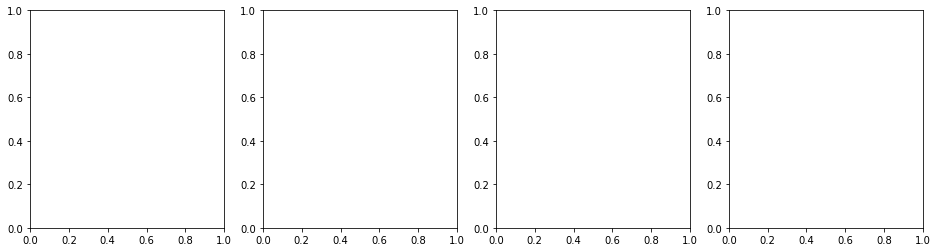

In [301]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_corr[gf],SU_corr_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_corr[~gf],SU_corr_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_corr[gf],SU_corr_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_corr[~gf],SU_corr_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_corr[gf],SU_corr_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_corr[~gf],SU_corr_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_corr[gf],SU_corr_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_corr[~gf],SU_corr_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat corr (raw)')
    ax.set_ylabel('nas/mat corr after step')
fig1.tight_layout()

In [622]:
SU_corr_PCA.shape

(1475,)